In [98]:
# PROGRAM DESCRIPTION:
# This program is a simple example of a shallow polynomial neural network (SPNN) 
# with a single output
# 1) Generate a training data set for a given homogeneous polynomial using regular lattice + noise
# 2) Train our SPNN 
# 3) Generate a test data set to check a model performance
# 
# SOME REMARKS:
# For a given SPNN architecture or a homogeneous polynomial, changing the dimension of 
# a hidden layer shows an interesting behavior during the training process
#
# MIT License
# 
# Copyright (c) 2024 Maksym Zubkov
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

In [99]:
# IMPORT ALL NECESSARY LIBRARIES

In [100]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [101]:
# DEFINE SPNN CLASS AND ALL NECESSARY FUNCTIONS

In [102]:
class SimpleDPN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, poly_order):
        super(SimpleDPN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.poly_order = poly_order  # Order of polynomial activation
        
        # Adding bias=False to disable the bias term
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim, bias=False)  # First fully connected layer
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim, bias=False)

        self.poly_act = PolynomialActivation(poly_order) # Polynomial activation instance
        
    def forward(self, x):
        x = self.poly_act(self.fc1(x))  # Apply polynomial activation after first fully connected layer
        x = self.fc2(x)  # No activation 
        return x

class PolynomialActivation(nn.Module):
    def __init__(self, order):
        super(PolynomialActivation, self).__init__()
        self.order = order

    def forward(self, x):
        return torch.pow(x, self.order)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            # Check if the layer has bias term
            if m.bias is not None:
                m.bias.data.fill_(0.01)
                
def custom_initialize_weights(model, custom_weights, custom_biases=None):
    i = 0  # Index for iterating through custom weights and biases
    for m in model.modules():
        if isinstance(m, nn.Linear):
            m.weight.data = custom_weights[i]
            if m.bias is not None and custom_biases is not None:
                m.bias.data = custom_biases[i]
            i += 1

def generate_lattice(n, dimensions, step_sizes, marker=None, dtype=np.float64):
    if len(dimensions) != n or len(step_sizes) != n:
        raise ValueError(f"Length of dimensions ({len(dimensions)}) and step_sizes ({len(step_sizes)}) must be equal to n ({n})")
    
    if marker is not None and len(marker) != n:
        raise ValueError(f"Length of marker ({len(marker)}) must be equal to the number of dimensions ({n})")
    
    # Generate the lattice using NumPy's meshgrid function
    grids = np.meshgrid(*[np.arange(0, dim+step, step, dtype=dtype) for dim, step in zip(dimensions, step_sizes)], indexing='ij')
    
    # Reshape and stack the arrays to create coordinates for all points in the lattice
    lattice = np.vstack([grid.ravel() for grid in grids]).T.astype(dtype)

    # Add the marker to each point, if specified
    if marker is not None:
        lattice += np.array(marker, dtype=dtype)
    
    return lattice

def plot_lattice(X, w):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create the scatter plot
    sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=w, cmap='jet')
    
    # Add a color bar to show the mapping from 'w' values to colors
    cbar = plt.colorbar(sc, aspect=30)
    cbar.set_label('w value')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Lattice Plot')
    plt.show()

In [103]:
# INITIALIZE SPNN PARAMETERS 

In [104]:
d0 = 3 # 1st layer dimension
d1 = 2 # hidden layer dimension
order = 2 # order of an activation function
epochs = 500 
train_loss_history = []

In [105]:
# GENERATE TRAINING DATA SET

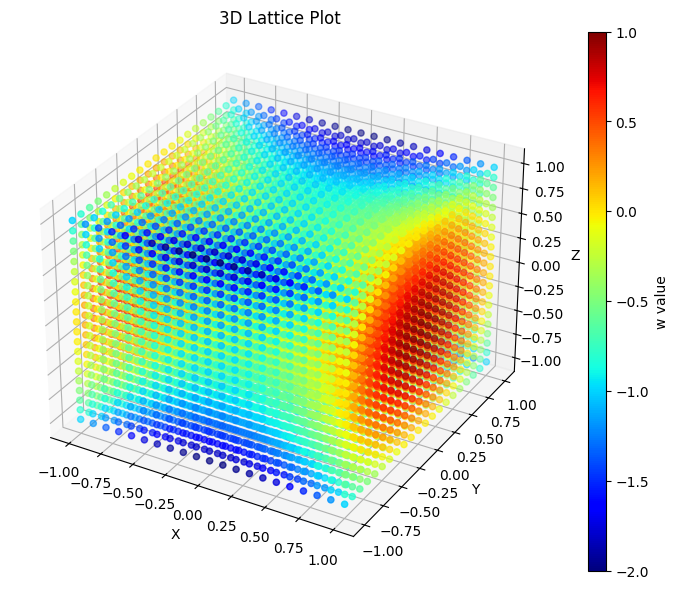

In [106]:
np.random.seed(0) # Setting a seed for reproducibility
noise_level = 0  # Standard deviation of the noise

# Set regular lattice dimensions
n = 3
dim = 1
dimensions = [2*dim]*n
step_sizes = [0.1]*n
marker = [-dim]*n

# Generate a lattice and noise
lattice = generate_lattice(n, dimensions, step_sizes, marker)
noise = np.random.normal(0, noise_level, len(lattice))  # Gaussian noise

# Generate outputs for a given homogeneous polynomial
x = lattice[:, 0]
y = lattice[:, 1]
z = lattice[:, 2]
w = x**2 - y**2 - z**2 + noise

# Save and plot
X_train=lattice
w_train=w.reshape(-1,1)
plot_lattice(X_train, w_train)

# Change into pytorch format
X_train = torch.tensor(X_train, dtype=torch.float32) # Convert NumPy arrays
w_train = torch.tensor(w_train, dtype=torch.float32) # to PyTorch tensors

In [107]:
# INITIALIZE THE MODEL

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dpn = SimpleDPN(input_dim=d0, hidden_dim=d1, output_dim=1, poly_order=order)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(dpn.parameters(), lr=0.01)  # Adam optimizer

In [109]:
# TRAIN THE MODEL

In [110]:
initialize_weights(dpn) 

dpn.train()  # Set the model to training mode
for epoch in range(epochs):
    optimizer.zero_grad()  # Zero the gradient buffers
    output = dpn(X_train)  # Forward pass
    loss = criterion(output, w_train)  # Loss calculation
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    train_loss_history.append(loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/500], Loss: 0.0001
Epoch [200/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000


In [111]:
# PLOT THE LOSS FUNCTION

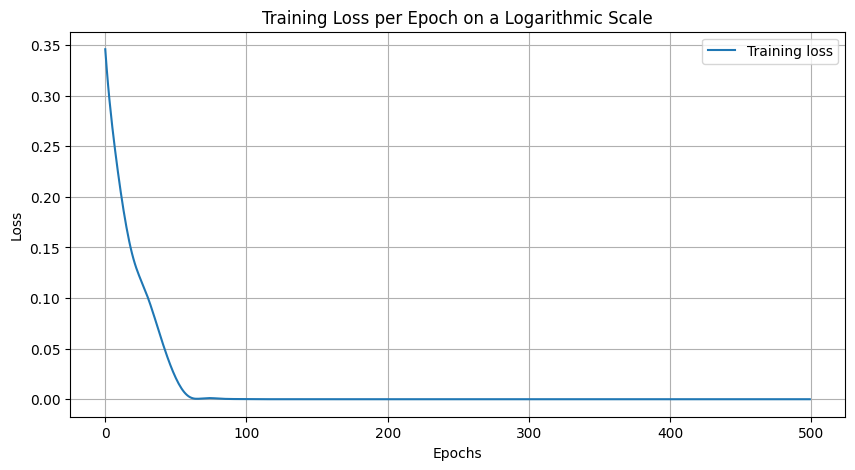

In [112]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_history, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch on a Logarithmic Scale')
plt.legend()
plt.grid(True)
plt.show()
        

In [113]:
# GENERATE TEST DATA

In [114]:
n = 3
dimensions = [4]*n
step_sizes = [0.2]*n
marker = [-2]*n
X_test = generate_lattice(n, dimensions, step_sizes, marker)
x = X_test[:, 0]
y = X_test[:, 1]
z = X_test[:, 2]
w = x**2 - y**2 - z**2 

X_test = torch.tensor(X_test, dtype=torch.float32)         # Convert NumPy arrays
w_test = torch.tensor(w, dtype=torch.float32).unsqueeze(1) # to PyTorch tensors

In [115]:
# TEST THE MODEL

Test Loss: 0.0000


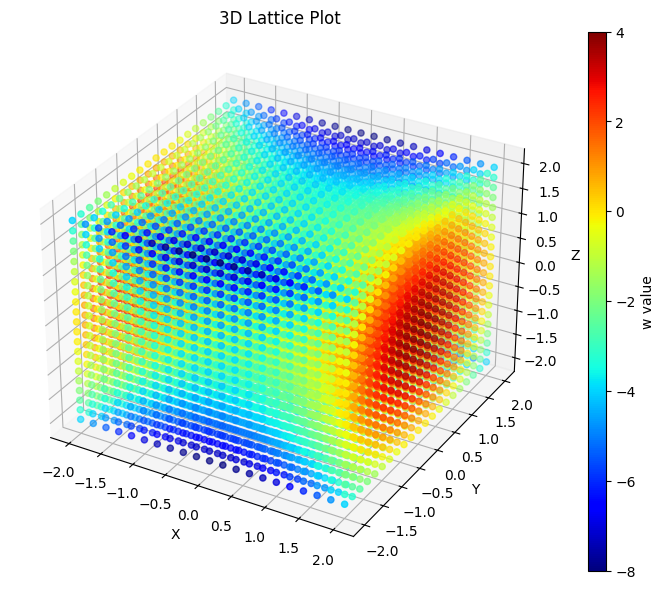

In [116]:
dpn.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_output = dpn(X_test)
    test_loss = criterion(test_output, w_test)
print(f'Test Loss: {test_loss.item():.4f}')

X_test_np = X_test.cpu().detach().numpy()           # Convert them from
test_output_np = test_output.cpu().detach().numpy() # PyTorch to NumPy

colors = np.around((test_output_np.T)[0], decimals=2)
plot_lattice(X_test_np, colors)